# Classification

Say that you want to build an algorithm that recognizes whether a picture is that of a dog or a cat.  This is a **classification** problem.  One is given a set of data $Z = \{(X_n, Y_n), n = 1, \ldots, M\}$ where the $Y_n$ take value in a finite set ${\cal Y}$ and the $X_n = (X_n(1), \ldots, X_n(d))^T$ take values in $\Re^d$.  For instance, the $X_n$ are pictures and the $Y_n$ are labels in $\{dog, cat\}$.  As in the chapter **AI Approach**, one typically divides the data into a training and a testing set.  

The **accuracy** of a classifier is the fraction of correct classifications.  
When ${\cal Y} = \{0, 1\}$, one calls $0$ negative and $1$ positive. Let TP be the number of true positive (i.e., positive and classified as positive), FP the number of false positive (negative and classified as positive), and similarly for negatives.  Let also $N = TN + FP$ be the number of negative cases and $P = TP + FN$ the number of positive cases. One defines the metrics shown in the figure below:

![title](Figures/confusion.pdf)

The best classifier maximizes the sensitivity (i.e., the probability of correct detection) for a given upper bound on the probability of false positive. 


In this chapter we explain the following approaches:

* K Nearest Neighbors
* Decision Tree
* Separation Hyperplane
* Support Vector Machine with Kernel
* K-neighbors
* Logistic Regression
* Neural Network Classification.




In [2]:
# First, import some general libraries

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
matplotlib.rcParams.update(params)
import scipy
import pandas as pd
import openpyxl
import random
import ipywidgets as widgets
from ipywidgets import *
import sklearn

print('The libraries loaded successfully')

The libraries loaded successfully


## K Nearest Neighbors

This classification method is elementary.  For a given $X$, one finds the $K$ nearest values of $X_n$ to $X.$  One then lets $Y$ be the majority value of $Y_n$ for that set.

We try that method when $X_n$ is uniform in $[0, 1]$ and $Y_n = 1\{X_n \in A\}$ where $A$ is a union of finitely many disjoint intervals in $[0, 1]$.



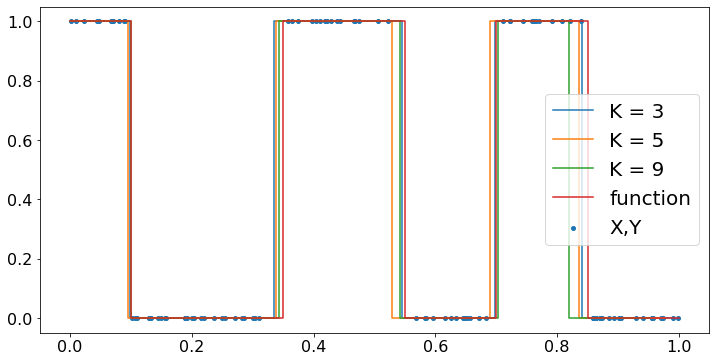

In [74]:
Af = [[0, 0.1], [0.35, 0.55], [0.7, 0.85]]
N = 100
X = np.zeros(N)
Y = np.zeros(N)
Z = np.zeros([2,N])
for n in range(N):
    X[n] = np.random.uniform(0,1)
    for i in range(len(Af)):
        Y[n] = max(Y[n], Af[i][0] <= X[n] and X[n] <= Af[i][1])
def byX(item):
    return item[0]
Z = [[X[n],Y[n]] for n in range(N)]
Z.sort(key=byX)
        
# We look for the break points B where K-means function changes values and the values C of the function

Kset = [3,5,9]
i = 0
for K in Kset:
    B = [0] 
    C = []
    A = Z[:K] # current set of closest neighbors
    Inext = K # index of next point
    while Inext < N:
        J = [item[1] for item in A]
        C.append((np.average(J)>0.5))
        B.append((A[0][0] + Z[Inext][0])/2)
        del A[0]
        A.append(Z[Inext])
        Inext += 1
    J = [item[1] for item in A]
    C.append((np.average(J) > 0.5))        
    plt.step(B,C,where='post',label='K = '+str(K))      
        
        
S = []
V = []
for i in range(len(Af)):
    S.append(Af[i][0])
    V.append(1)
    S.append(Af[i][1])
    V.append(0)
S.append(1)
V.append(0)
plt.scatter(X,Y,label='X,Y')
plt.step(S,V,where='post',label='function') 
plt.legend()
plt.show()

## Decision Tree

A decision tree is similar to a regression tree. It is constructed by splitting the data set $Z$ into two subsets $Z_0$ and $Z_1$ and then continuing in the same way for the subsets.  
The split is designed to maximize the gain achieved by the split.  Typically, the split is based on a threshold for a component of $X_n$ (a *feature*).  Maximimzing the gain corresponds to choosing a feature and a threshold value.

There are a number of measures of this gain.  

### Information Gain

The intuition is that the split reduces the uncertainty about the label $Y$.  At one extreme, the split is such that the labels are $y_0$ in $Z_0$ and $y_1$ in $Z_1$. In this case, there is no uncertainty after the split.  Before the split, one can measure the uncertainty by the entropy $H(Z)$ defined by

$$H(Z) = - \sum_{y \in {\cal Y}} p_Z(y) \log p_Z(y)$$

where $p_Z(y)$ is the fraction of items in $Z$ with $Y_n = y$.  A more realistic situation is that the uncertainty is not zero after the split but is $H(Z_0)$ in $Z_0$ and $H(Z_1)$ in $Z_1$.  The average uncertainty after the split is then defined as 

$$\frac{|Z_0|}{|Z|} H(Z_0) + \frac{|Z_1|}{|Z|} H(Z_1).$$

The reduction in uncertainty after the split is then

$$G(Z_0, Z_1) = H(Z) - \frac{|Z_0|}{|Z|} H(Z_0) - \frac{|Z_1|}{|Z|} H(Z_1).$$

When using this metric, one chooses the split to maximize the information gain $G(Z_0, Z_1)$.

To gain some intuition about the meaning of entropy, consider sequence $Y_1, Y_2, \ldots, Y_N$ of i.i.d. random variables that take the value $y$ with probability $p_y$ for $y \in {\cal Y}$.  The probability of a sequence where a fraction $f_y$ of these random variables is equal to $y$ for $y \in {\cal Y}$ is given by

$$\Pi_{y \in {\cal Y}} p_y^{N f_y}.$$

Since for large $N$ one has $f_y \approx p_y$, the probability of a typical sequence is then

$$\Pi_{y \in {\cal Y}} p_y^{N p_y} = 2^{- N \times H}$$

where $H = - \sum_y p_y \log p_y$.  This shows that all the typical sequences (that are likely to occur) have the same probability and that, consequently, there are $2^{N \times H}$ typical sequences.  Accordingly, it takes $N \times H$ bits to specify which typical sequence occurred.  Thus, the entropy is the number of bits of information required to specify the value of $Y$, on average.

### Gain Ratio

By splitting $Z$ finer and finer, one ultimately reduces the uncertainty to $0$, however, the resulting classifier does not generalize.  The gain ratio measures the ratio of the information gain divided by the entropy of the split defined by

$$S(Z_0, Z_1) = - \frac{|Z_0|}{|Z|} \log \frac{|Z_0|}{|Z|} - \frac{|Z_1|}{|Z|} \log \frac{|Z_1|}{|Z|}.$$

Thus, this method chooses the split that maximizes $G(Z_0, Z_1)/S(Z_0, Z_1)$.

### Gini Index

Instead of using the entropy to measure uncertainty, some methods use the Gini index defined by

$$Gini(Z) = 1 - \sum_{y \in {\cal Y}} \left[p_Z(y)\right]^2.$$

Those methods then choose the split that maximize the reduction in the Gini index

$$Gini(Z) - \frac{|Z_0|}{|Z|} Gini(Z_0) - \frac{|Z_1|}{|Z|} Gini(Z_1).$$


The inutitive meaning of the Gini index is somewhat similar to entropy: the higher the index, the more uncertain the value of the random variable.  For instance, if ${\cal Y} = \{0, 1\}$, the Gini index is 

$$1 - p_0^2 - p_1^2 = 1 - (p_0 + p_1)^2 + 2p_0p_1 = 2p_0p_1.$$

Like the entropy, this value is maximized when $p_0 = p_1 = 1/2$ and minimized when $p_0 = 1$ or $p_1 = 1$.

### Example

To get some sense of how these metric works, we look at a synthetic example.  For $n = 1, \ldots, N$, let $Y_n = 0$ and $X_n$ be uniform in $[0, 6]$.  For $n = N+1, \ldots, 2N$, let $Y_n = 1$ and $X_n$ be uniformly distributed in $[4, 10]$.  In the cell below, we split the data based on the three measures above.  

For the information gain, say that we split at the threshold value $x$.  This produces $Z_0 = \{[X_n, Y_n] \mid X_n < x\}$ and $Z_1 = \{[X_n, Y_n] \mid X_n \geq x\}$. We then compute $|Z_0|, H(Z_0), H(Z_1)$ and the resulting value of $G(Z_0, Z_1)$.  We then find the value of $x$ that maximizes this information gain. We proceed similarly for the other two metrics.  

The example shows that the splits are similar but are not always identical.  (Run the cell a few times.)

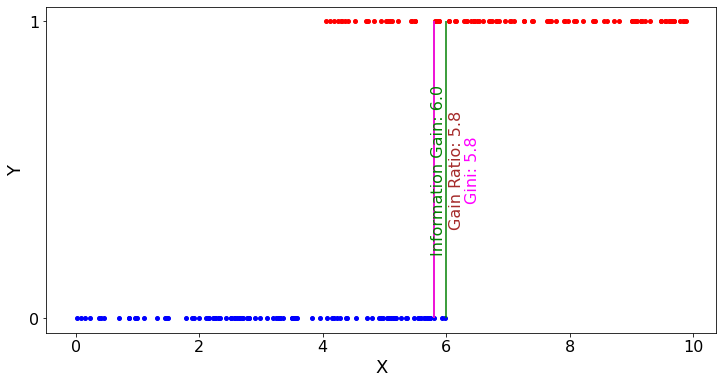

In [3]:
from matplotlib.pyplot import text
N = 100
X = np.zeros(2*N)
Y = np.zeros(2*N)
Z = np.zeros([2*N,2])
for n in range(N):
    X[n], X[N+n], Y[n], Y[N+n] = np.random.uniform(0,6), np.random.uniform(4,10), 0, 1
    Z[n,:] =  [X[n],Y[n]]
    Z[N+n,:] = [X[N+n],Y[N+n]]
    
def HG(Z): # entropy and Gini Index of Y in Z
    h = 0
    for item in Z:
        h += item[1]
    h = h/len(Z)
    if h in [0, 1]:
        return 0, 0
    else:
        return - h*np.log2(h) - (1 - h)*np.log2(1-h), 1 - h**2 - (1 - h)**2

def HS(Z,x): # average entropy and gini index of Z0 and Z1 when Z is split at x
    Z0 = []
    Z1 = []
    for item in Z:
        if item[0] < x:
            Z0.append(item)
        else:
            Z1.append(item)
    if len(Z0) == 0:
        return HG(Z1)[0],HG(Z1)[1] , 0
    elif len(Z1) == 0:
        return HG(Z0)[0], HG(Z0)[1], 1
    else: 
        a = (len(Z0)/len(Z))*HG(Z0)[0] + (len(Z1)/len(Z))*HG(Z1)[0]
        b = (len(Z0)/len(Z))*HG(Z0)[1] + (len(Z1)/len(Z))*HG(Z1)[1]
        return a, b, len(Z0)/len(Z)

def split(Z): # best split of set Z
    G = np.zeros(101)
    GR = np.zeros(101)
    GI = np.zeros(101)
    for k in range(101):
        G[k], GI[k], h = HS(Z,k/10)
        if h in [0, 1]:
            GR[k] = 1000 # a large number if there is no split
        else:
            GR[k] = G[k]/(- h*np.log2(h) - (1 - h)*np.log2(1-h))
    
    return np.argmin(G)/10, np.argmin(GR)/10, np.argmin(GI)/10

v, w, g = split(Z)
h = [v,w,g]

Y = [0 for n in range(N)]
Y.extend([1 for n in range(N)])
plt.scatter(X[:N],Y[:N],color = 'b')
plt.scatter(X[N:],Y[N:],color = 'r')
plt.yticks([0,1])
plt.ylabel('Y')
plt.xlabel('X')
plt.vlines(v, ymin=0, ymax=1, color = 'g')
text(v - 0.25*(1 - 2*(v < w)), 0.5, "Information Gain: "+str(v), rotation=90, verticalalignment='center',size= 16,color='g');
plt.vlines(w, ymin=0, ymax=1, color = 'brown')
text(w + 0.25*(1 - 2*(v < w)), 0.5, "Gain Ratio: "+str(w), rotation=90, verticalalignment='center',size= 16,color='brown');
plt.vlines(w, ymin=0, ymax=1, color = 'magenta')
text(g+0.5, 0.5, "Gini: "+str(g), rotation=90, verticalalignment='center',size= 16,color='magenta');


   


### Example 2

We construct a simple example to see how the decision tree classifier performs.  Say that houses are of two types $0$ and $1$.  Houses of type $0$ have a low cost per square foot and those of type $1$ have a high cost per square foot.  We generate two attributes for each house $n$:  $X_n(0)$ is the square footage and $X_n(1)$ is the price. The label is $Y_n$.  We see if the decision tree is able to recognize the type and how it does it. 

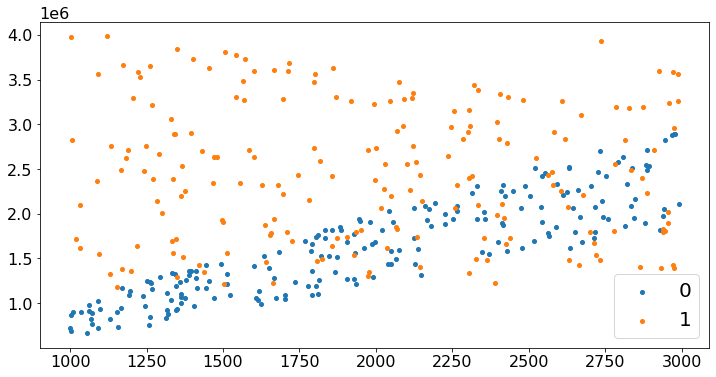

accuracy =  0.775


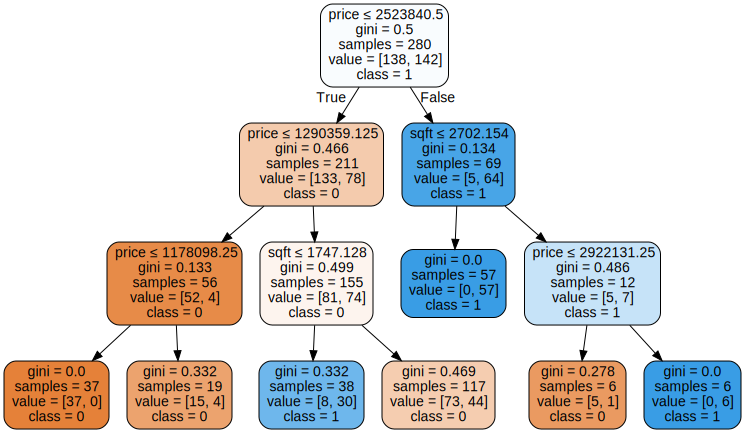

In [4]:
# pip instal graphviz
N = 200
X = np.zeros([2*N,2])
Y = np.zeros(2*N)
R = np.zeros(2*N)
for n in range(N):
    X[n,0] = np.random.uniform(1000, 3000)
    R[n] = np.random.uniform(600, 1000)
    X[n,1] = R[n]*X[n,0]
    Y[n] = 0
    X[N+n,0] = np.random.uniform(1000, 3000)
    R[N+n] = np.random.uniform(1100, 1400)
    X[N+n,1] = R[N+n]*X[n,0]
    Y[N+n] = 1
plt.scatter(X[0:N,0],X[0:N,1],label='0')
plt.scatter(X[N:,0],X[N:,1],label='1')
plt.legend()
plt.show()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=42)
from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   
clf_model.fit(X_train,y_train)
y_predict = clf_model.predict(X_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print('accuracy = ', accuracy_score(y_test,y_predict))



target = ['0','1']
feature_names = ['sqft','price']
from sklearn import tree

# extra step to allow graphviz to be found 
#import os
#os.environ["PATH"] += os.pathsep + '/Users/jeanwalrand/opt/anaconda3/lib/python3.7/site-packages/sphinx/ext/__pycache__/'


import graphviz
dot_data = tree.export_graphviz(clf_model,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

graph


The figure above shows the corresponding decision tree computed from the training data and the figure below provides another illustration.

![title](Figures/gini.pdf)


## Separating Hyperplane

Assume that ${\cal Y} = \{0, 1\}$.  The **separating hyperplance** approach computes a hyperplane that separates the values of $X$ that should be labelled $0$ from those that should be labelled $1$, as
shown in the figure below:

![title](Figures/SHP1.pdf)


The hyperplane is choosen to minimize the number of incorrect labels on the training data.  More precisely, it si chosen to maximize the **margin** defined as the minimum of the smallest distance between vectors with label $1$ and the half-space with labels $0$ and the corresponding distance with $0$ and $1$ interchanged. The figure below illustrates the definition of margin.

![title](Figures/SHP2.pdf)

When the margin is positive, finding the separating hyperplane is a convex optimization problem of minimizing a quadratic function subject to linear separation constraints.  Another approach is the support vector machine algorithm that explores vectors that support the margin hyperplanes. That approach allows for negative margins.

The cell below provides an example.

This is an excerpt from the Python Data Science Handbook by Jake VanderPlas; Jupyter notebooks are available on GitHub.  The text is released under the CC-BY-NC-ND license, and code is released under the MIT license. 

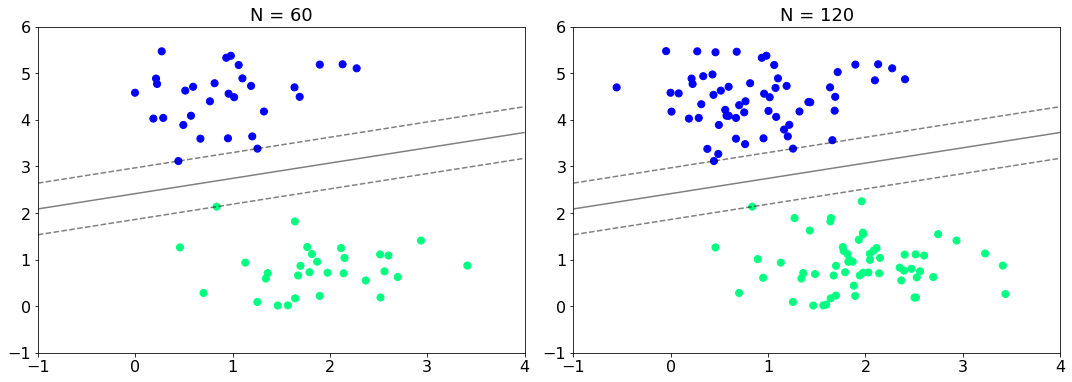

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.datasets import make_blobs

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))


## Kernel

In many situations, the vectors cannot be separated by a hyperplane but they can after being transformed by a kernel.  As a simple example, assume the vectors with label $0$ are randomly placed on a circle with radius $1$
with a small perturbation and vectors with label $1$ are randomly placed on a circle with radius $2$ with a small perturbation.  If one transforms the vectors $X = [X[0], X[1]]$ into $[X[0], X[1], X^2[0] + X^2[1]]$, the new 3D vectors can be separated by a hyperplane $Z[3] = 1.5$. The cell below illustrates that transformation.

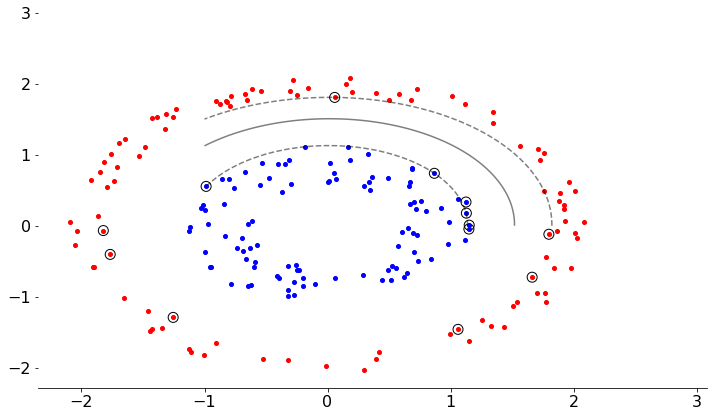

In [6]:
from sklearn import svm
N = 100
X = np.zeros([2*N,2])
for n in range(N):
    theta = np.random.uniform(0, 2*np.pi)
    r = np.random.uniform(0.6,1.2)
    X[n] = r*np.cos(theta), r*np.sin(theta)
for n in range(N):
    theta = np.random.uniform(0, 2*np.pi)
    r = np.random.uniform(1.8,2.1)
    X[N+n] = r*np.cos(theta), r*np.sin(theta)
x_train = X
y_train = [0 for n in range(N)]
y_train.extend([1 for n in range(N)])
model = svm.SVC(kernel='poly', degree=2)
model.fit(x_train, y_train)

fig, ax = plt.subplots(figsize=(12, 7))
# Removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# Create grid to evaluate model
xx = np.linspace(-1, max(X[:,0]) + 1, len(x_train))
yy = np.linspace(0, max(X[:,1]) + 1, len(x_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
train_size = len(X)
# Assigning different colors to the classes
colors = y_train
colors = np.where(colors == 1, '#8C7298', '#4786D1')
# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)
# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
ax.scatter([item[0] for item in X[:N]], [item[1] for item in X[:N]],color='b')
ax.scatter([item[0] for item in X[N:]], [item[1] for item in X[N:]],color='r')
plt.show()

## Logistic Regression

Say that the labels are ${\cal Y} = \{0, 1\}$ and $X_n \in \Re^d$. We consider a classifier of the form

$$Y = f(X) := g(-5 + a_1X_1 + a_2X_2 + \cdots + a_d X_d)$$

where

$$ g(u) = \frac{\exp\{u\}}{1 + \exp\{u\}}.$$

The value $-5$ for the constant is somewhat abrbitrary.  It is fixed here to avoid indeterminacy and is large enough for $f(X)$ to approximate $0$ and $1$.

Note that $g(u) \approx 0$ if $u \ll 0$ and $g(u) \approx 1$ if $u \gg 0$.  Thus, with suitable coefficients $a_k$, the value of $g(20 + a_1X_1 + a_2X_2 + \cdots + a_d X_d)$ will be close to either $0$ or $1$.

We can use SGD to find a good value of $a$.  The algorithm is

$$a_k[n+1] = a_k[n] - \delta \times \frac{\partial}{\partial a_k} \frac{1}{2} [f(X[n]) - Y[n]]^2.$$

Thus,

$$a_k[n+1] = a_k[n] - \delta [f(X[n]) - Y[n]]X_k[n] g'(-1 + a_1X_1[n] + a_2X_2[n] + \cdots + a_d X_d[n])$$

where

$$g'(u) = g(u)  -  \exp\{2 u\}/(1 + \exp\{u\})^2  = g(u)(1 - g(u).$$

### An Example

We implement this algorithm in the cell below in an example where $Y = 1\{-5 + 10*X_1 > 0\}$.  We expect $a_1$ to converge to $10$. 

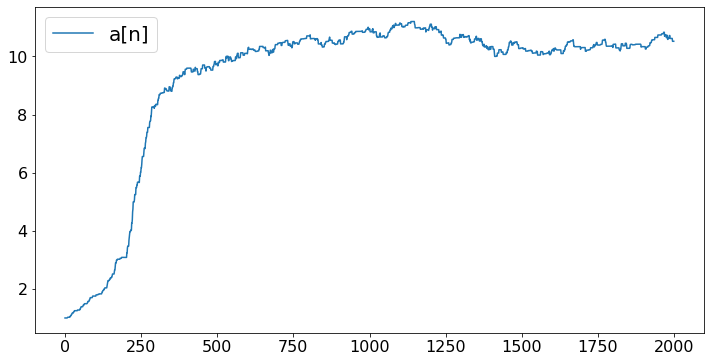

In [17]:
N = 100
X = np.zeros(N)
Y = np.zeros(N)
R = np.zeros(N)
for n in range(N):
    X[n] = np.random.uniform(-1, 1)
    Y[n] = (-5 + 10*X[n] > 0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=42)

def g(u):
    if u > 10:
        return 1
    elif u < -10:
        return 0
    else:
        v = np.exp(u)
        return v/(1 + v)
def gp(u):
    return g(u)*(1 - g(u))

delta = 2
M = len(X_train)
Iter = 2000
a = np.zeros(Iter)
a[0] = 1
for k in range(Iter-1): # bootstrap
    j = random.choice(range(M))
    x, y = X_train[j], y_train[j]
    u = -5 + a[k]*x
    a[k+1] = a[k] - delta*(g(u) - y)*x*gp(u)
plt.plot(a[:],label= 'a[n]')
plt.legend()
plt.show()

### Adapting the step size

As the example above shows, choosing the step size is somewhat of a guessing game.  It is a tradeoff between speed of convergence and accuracy.  It is sensible to adjust the step size.  One idea is to choose $\delta$ so that the size of $h(X) := \delta \times \nabla (1/2) [f(X) - Y]^2$ is within the desired accuracy.  To estimate the size of $h(X$, we use an exponential moving average.  We increase $\delta$ is the estimated value of $h(X)$ is too small and we decrease it otherwise.  We try that in the next cell. This is in the same spirit as the Adam algorithm.

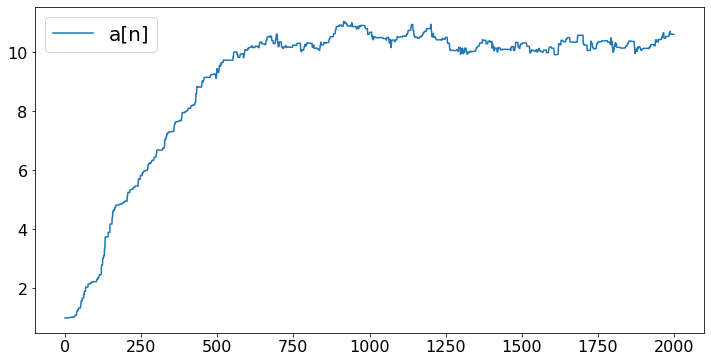

In [35]:
N = 100
X = np.zeros(N)
Y = np.zeros(N)
R = np.zeros(N)
for n in range(N):
    X[n] = np.random.uniform(-1, 1)
    Y[n] = (-5 + 10*X[n] > 0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=42)

def g(u):
    if u > 10:
        return 1
    elif u < -10:
        return 0
    else:
        v = np.exp(u)
        return v/(1 + v)
def gp(u):
    return g(u)*(1 - g(u))

delta = 0.5
M = len(X_train)
Iter = 2000
a = np.zeros(Iter)
a[0] = 1
h = 0
for k in range(Iter-1): # bootstrap
    j = random.choice(range(M))
    x, y = X_train[j], y_train[j]
    u = -5 + a[k]*x
    a[k+1] = a[k] - delta*(g(u) - y)*x*gp(u)
    h = 0.95*h + 0.05*abs(delta*(g(u) - y)*x*gp(u))
    delta += 0.1*(1 - 2*(h > 0.015))
    delta = max(0.1,delta)
plt.plot(a[:],label= 'a[n]')
plt.legend()
plt.show()

## Neural Network Classification

In section **Regression with a Neural Network** of chapter **AI Approach** we explained how to fit a function with a neural network.  Say that one uses a neural network to construct a function $f$ such that $f(X_n) \approx Y_n$ for $(X_n, Y_n)$ in the training set.  If $Y_n$ belongs to $\{0, 1\}$, one can the replace $f(X_n)$ by the closest value in $\{0, 1\}$.  Let's try that approach.  For simplicity, $X_n$ is uniform in $[0, 1]$ and $Y_n = 1\{X_n \in A\}$ where $A$ is a union of finitely many disjoint intervals in $[0, 1]$.  We use a one-layer network with ReLU neurons, as in the section mentioned above.

a =  [-0.94827004  0.07202513  0.12061061  0.1691961   0.21778158  0.26636707
  0.31495255  0.36353803  0.41212352  0.460709    0.50929449  0.55787997
  0.60646546  0.65505094  0.70363642  0.75222191  0.80080739  0.84939288
  0.89797836  0.94656385]


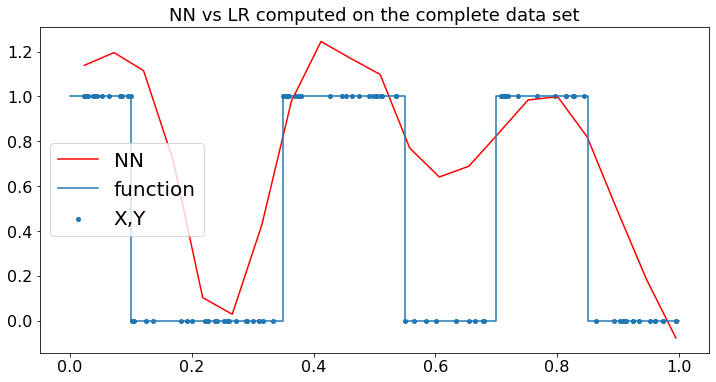

In [65]:
A = [[0, 0.1], [0.35, 0.55], [0.7, 0.85]]
N = 100
X = np.zeros(N)
Y = np.zeros(N)
for n in range(N):
    X[n] = np.random.uniform(0,1)
    for i in range(len(A)):
        Y[n] = max(Y[n], A[i][0] <= X[n] and X[n] <= A[i][1])

def fnn(x,a,b): # define the neural network function
    v = 0
    for k in range(len(a)):
        v+= b[k]*max(x - a[k],0)
    return v

def fitNN(X,Y,K,boost,delta):  # K neurons, boot*M resampling, delta = step size   
    M = len(X) # the number of data points
    N = boost*M # the number of iterations with bootstrap
    b = np.zeros([N,K])
    a = np.zeros(K)
    a[0] = min(X) - (max(X) - min(X)) # this allows to choose the value at min(HA)
    for k in range(1,K):  # spread corner points evently  
        a[k] =  min(X) + (k/K)*(max(X) - min(X))
    b[0,:] = np.random.uniform(-1,1,K)# why not?
    for n in range(N-1):
        for k in range(K):
            m = random.choice(range(M)) # bootstrap
            x, y = X[m], Y[m]
            b[n+1,k] = b[n,k] - delta*(fnn(x,a,b[n,:])- y)*max(0,x - a[k])
    # Note that we do not update the a[k] in this algorithm.  We could have  
    return a, b[N-1,:]


 
def plotFitNN(X,Y,a,b):
    xaxis = [min(X) + 0.01*n*(max(X) - min(X)) for n in range(101)]
    y = [fnn(x,a,b) for x in xaxis]
    plt.plot(xaxis,y,color='r',label='NN')
    

    
def rmseNN(X,Y,a,b):
    x = 0
    for n in range(len(X)):
        x += (Y[n] - fnn(X[n],a,b))**2
    x = (x/len(X))**(0.5)
    y = x/abs(np.average(Y))
    return round(100*y,1)
    
    
a, b = fitNN(X,Y,20,100,0.35)
plotFitNN(X,Y,a,b)
S = []
V = []
for i in range(len(A)):
    S.append(A[i][0])
    V.append(1)
    S.append(A[i][1])
    V.append(0)
S.append(1)
V.append(0)
plt.scatter(X,Y,label='X,Y')
plt.step(S,V,where='post',label='function') 
plt.legend()
plt.title('NN vs LR computed on the complete data set')
plt.show()

